In [1]:
#Imports
#!pip install itertools
from pathlib import Path
import graphviz
import networkx as nx
import itertools

ModuleNotFoundError: No module named 'graphviz'

# Burrows Wheeler Transform on Yeast Data

In [ ]:
#Burrows Wheeler Transform
def BurrowsWheeler(sequence: str):
    sequence = "$"+sequence
    rotations = [] 
    for i in range(len(sequence)):
        rotations.append(sequence[-i:]+sequence[:-i])
    rotations.sort()

    return "".join([letter[-1] for letter in rotations])

In [ ]:
#inverse Burrows Wheeler (Walk Left Algorithm)
def Occ(bw:str, letter: chr): # number of characters < character alphabetically
    bwList = [ord(sym) for sym in bw]
    return (sum([sym < ord(letter) for sym in bwList]))
    
def Count(bw, idx, letter): # number of characters before position with letter 
    bwList = [ord(sym) for sym in bw]
    bwList = bwList[:idx]
    return sum([ord(letter) == sym for sym in bwList])

def LF(bw, idx, letter): #matches character and rank
    return Occ(bw, letter) + Count(bw, idx, letter)

def invBurrowsWheeler(bw: str, i=0):
    #i = 0
    t = ""
    while bw[i] != "$":
        t = bw[i] + t
        i = LF(bw, i, bw[i])
        
    return(t)

In [ ]:
bw = BurrowsWheeler('abcdefghijklmn')
print(bw)
invBurrowsWheeler(bw)

n$abcdefghijklm


'abcdefghijklmn'

In [ ]:
#Exact Matching with FM index
def FM_Matching(bw:str, query:str):
    top = 0
    bot = len(bw)
    for qc in query[::-1]:
        top = LF(bw, top, qc)
        bot = LF(bw, bot, qc)
        if top == bot:
            #print("Query not in Reference")
            return 0
    
    #print("Query in Reference at position " + str(len(invBurrowsWheeler(bw, i=top))+1) + ".")
    return len(invBurrowsWheeler(bw, i=top))

In [ ]:
#Open Files
#Partial Reads
file = Path.cwd() / 'yeast_chr1_reads.txt'
with open(file, 'r') as text:
    textfile = text.read()
    reads = textfile.splitlines()
    
#Reference
file = Path.cwd() / 'yeast_chr1_10k.txt'
with open(file, 'r') as text:
    reference = text.read()

In [ ]:
bw = BurrowsWheeler(reference)
matchIdx = []
for read in reads:
    matchIdx.append(FM_Matching(bw,read))
    if matchIdx[-1] ==0:
        print(read + ", Match Idx: None")
    else:
        print(read + ", Match Idx: " + str(matchIdx[-1]))

AATAGAATAACAGTTGTATGGGTCACCTGG, Match Idx: 8024
GGAAATTTATATATAAACTTCATTTACGTC, Match Idx: 7126
TGTATTCGTATGCGCAGAATGTGGGAATGC, Match Idx: 2453
ACTGCCAAATTTTTCTTGCTCATTTATAAT, Match Idx: 3086
GTACTTTGAAACCTGATTTATATATTGCAG, Match Idx: 6565
ACTTACCCTACTCTCAGATTCCACTTCACT, Match Idx: 459
TTCAGGACTTGCAAAAAGAATCTAACTGAT, Match Idx: 6980
AAATATTTGATTCATTATTCGTTTTACTGT, Match Idx: 4516
TAATATAACTTATCAGCGGCGTATACTAAA, Match Idx: 1181
AACATTGCAGCATAAATGCAAACCATTTGG, Match Idx: 7594
CTAGTTACAGTTACACAAAAAACTATGCCA, Match Idx: 1293
TTATGATATTTTTTTTTTATAGTAGTAGTG, Match Idx: 6940
TATTTTATTTTGTTCGTTAATTTTCAATTT, Match Idx: 1741
GCCTTATAAAACCCTTTTCTGTGCCTGTGA, Match Idx: 2504
TTTTCCACACCATGTTTAGAGTTATAAAGC, Match Idx: 7284
AAGTTAATATTATGGTGGTAGTATCTCAAA, Match Idx: 4660
TACTTACTACCACTCACCCACCGTTACCCT, Match Idx: 195
TCCATTCCCATATGCTAACCGCAATATCCT, Match Idx: 1017
AGTTTGGTACCATGACTTGTAACTCGCACT, Match Idx: 1375
TACAAATATATATTAAAGAAATCCAAACAA, Match Idx: 10326
GTTTTTTTAGTAATTTCTTTGTAAATACAG, Match Idx

# Library Complexity 

### Imagine you are responsible for sequencing DNA samples for your lab's latest important experiment. Using extensive simulations, you know that you need to observe at least 12 million unique molecules in order to test your current hypothesis. From previous experience, you know that each time a DNA library is constructed from a sample, it will contain exactly 40 million unique molecules (selected perfectly at random). You also know that, your model organism, has a genome size of approximately 100 million base pairs.You can have your sample sequenced in units called lanes. Each lane gives you 10 million reads, and a library can be sequenced on as many lanes as you want. However, ever-protective of your grant money, you want to achieve your experimental goals in the most efficient way possible. Suppose that each sample collection and library preparation step costs 500 dollars and that each sequencing lane costs 1000 dollars.

#### Assume that each molecule in the library had equal probability of being sequenced. What is the most cost-effective experimental design (number of libraries and lanes sequenced for each library) for achieving your goal of observing 12 million unique molecules? Show your work.

For this probelm we will use the equation
$$ M = C(1-poisson(x_i=0, \lambda = {N \over C})) $$

Where $M$ is the number of estimated molecules, $N$ is the reads per lane (10 million), and $C$ is the size of all libraries. We must take into consideration overlapping reads when obtaining multiple libraries. For 2 libraries we expect get $(100({40 \over 100})^2) = 16$ overlapping data points. Using this information we get the following table:

Num Libraries | Est. Molecules in Libraries(s) |  Num Lanes per library | Est. Unique Molecules | Price
:---:|:---:|:---:|:---:|:---:
1 | 40M |1 | 8.8M | 1500
1 | 40M |2 | 15.7M | 2500
2 | 64M |1 | 9.2M | 3000

If we add any more than 2 libraries or more than 1 lane for 2 libraries we end up spending more than the case with 1 library and 2 lanes so the most price efficient design us 1 library and 2 lanes.

#### Now suppose that there is variation in the selection probabilities across each molecule, which follows a negative binomial distribution with rate lambda = 0.25 (10 million reads divided by 40 million molecules) and variance factor k = 2 (estimated from previous experiments). What is the most cost-effective experimental design for this situation? Show your work and comment on any differences between the two cases.

The probelm is very similar but we instead use the negative binomial distribution in our equation giving us:

$$ M = C(1-NBpdf(x_i=0,n = {1 \over k}, p = {N \over N + {C \over K}})) $$

This gives us the following table

Num Libraries | Est. Molecules in Libraries(s) |  Num Lanes per library | Est. Unique Molecules | Price
:---:|:---:|:---:|:---:|:---:
1 | 40M |1 | 7.34M | 1500
1 | 40M |2 | 11.7M | 2500
1 | 40M |3 | 14.7M | 3500
2 | 64M |1 | 11.74M | 3000

This gives us the best cost being 1 library with 3 lanes.

#  de Bruijn Graphs

Suppose you are interested in sequencing a particular RNA sequence. You opt to take a next 
generation sequencing approach and submit your sample to your local sequencing facility. You 
receive the following set of 6 bp reads in return, which are all in the same orientation. 
AGCTGT, CAGCTG, TTCTGC, GCTGTA, TCAGCT, CTGTAT, TGTAGC, TTCAGC, 
CTGTAG, TTTCAG 

Construct the corresponding de Bruijn graph with k = 5 

Simplify any chains in the graph. Remove any tips present in the graph. 

Identify any bubbles in the graph. Resolve the bubbles by removing the path 
most likely to be caused by a sequencing error. 

Which read(s) contain sequencing errors? Identify the error(s). 

Write the sequence represented by the de Bruijn graph after the error 
correction steps.

In [ ]:
def deBruijn(reads:list, k:int, DisplayGraph=True):
    graphDict = {}
    
    for read in reads:        
        # Get K-mers
        Kmers = [] 
        for i in range(len(read)):
            if len(read[i:i+k])==k:
                Kmers.append(read[i:i+k])
        
        #Get L and R K-1-mers
        lkmer =[]
        rkmer =[]
        for Kmer in Kmers:
            lkmer.append(Kmer[0:len(Kmer)-1])
            rkmer.append(Kmer[1:len(Kmer)])
            
            graphDict.setdefault(lkmer[-1], [])
            graphDict[lkmer[-1]].append(rkmer[-1])
            
    #Remove Tips
    for key in graphDict.keys():
        lst = graphDict[key]
        simplifiedEdges = []
        if len(lst) <= 1:
            continue
        mostCommon = max(set(lst), key=lst.count)
        for val in graphDict[key]:
            if graphDict.get(val) is None:
                simplifiedEdges.append(mostCommon)
            else:
                simplifiedEdges.append(val)
        
        graphDict[key] = [mostCommon for i in lst]
        
    #Get path(s)
    G = nx.digraph.DiGraph()
    
    for key in graphDict.keys():
        for val in graphDict[key]:
            G.add_edge(key, val)
    if nx.is_eulerian(G):
        longestPath = eulerian_circuit(G)
    else:
        try:
            path = nx.dag_longest_path(G)
            longestPath = (path[0]+"".join([x[-1] for x in path[1:]]))
        except:
            longestPath = "Cycle in non-Eulerian de Bruijn Graph, sequence cannot be inferred"
        
    if DisplayGraph:
        #Rewrite multiple edges as Weights
        for key in graphDict.keys():
            weightedEdge = []
            for val in graphDict[key]:
                if (graphDict[key].count(val), val) in weightedEdge:
                    continue
                else:
                    weightedEdge.append((graphDict[key].count(val), val))
            graphDict[key] = weightedEdge
            
        #Create Graph
        deBruijnGraph = graphviz.Digraph(comment='de Bruijn Graph')
        #Create Nodes
        for key in graphDict.keys():
            deBruijnGraph.node(key,key)

        #Create Edges
        for key in graphDict.keys():
            for val in graphDict[key]:
                deBruijnGraph.edge(key, val[1], label=str(val[0]))

        display(deBruijnGraph)
    
    return longestPath

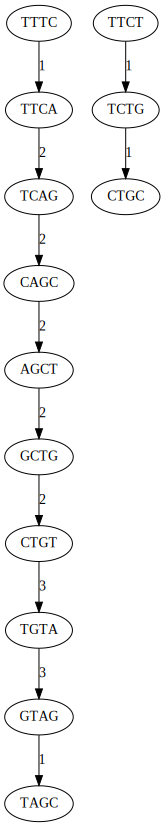

'TTTCAGCTGTAGC'

In [ ]:
seqs = ['AGCTGT', 'CAGCTG', 'TTCTGC', 'GCTGTA', 'TCAGCT', 'CTGTAT', 'TGTAGC', 'TTCAGC', 'CTGTAG', 'TTTCAG']
deBruijn(seqs,5)

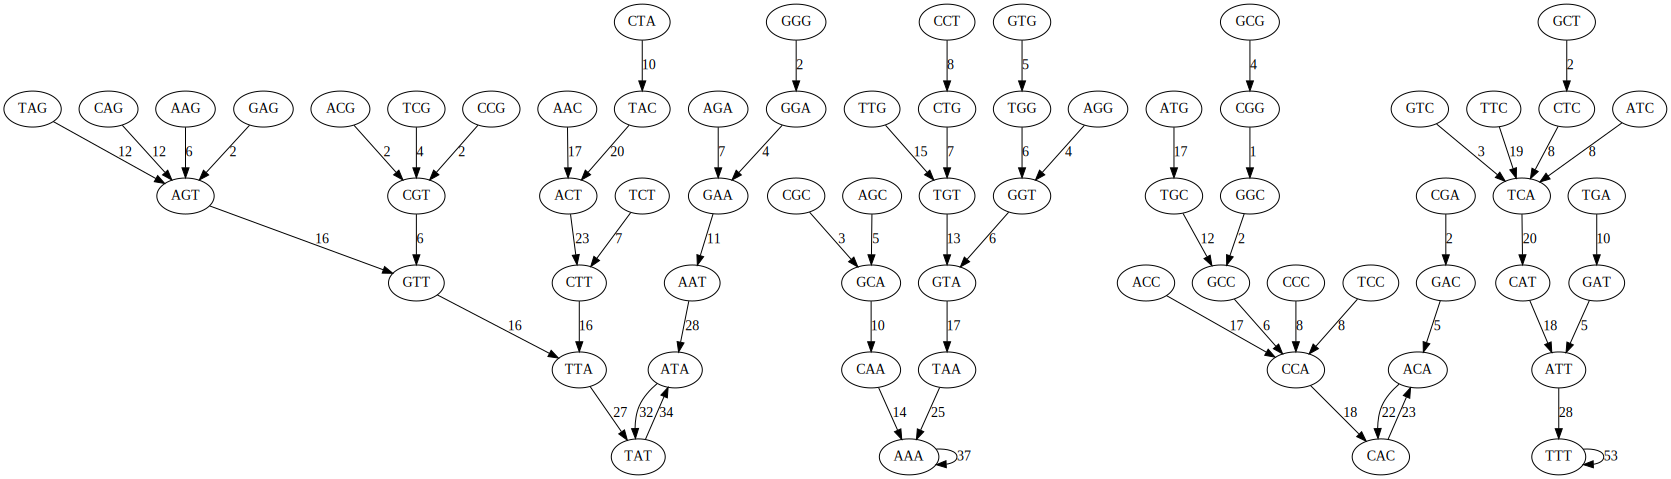

'Cycle in non-Eulerian de Bruijn Graph, sequence cannot be inffered'

In [ ]:
#Try on previous yeast data
deBruijn(reads,4)